In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import os
from random import random
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow import keras

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
# from tensorflow_addons.layers.normalization.instancenormalization import InstanceNormalization

2.0.0


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(tf.test.gpu_device_name())
print(device_lib.list_local_devices())

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8246799516918855533
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17405928471818755671
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8045497473856118741
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8007529268
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12930949503878135354
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:00:05.0, compute capability: 6.1"
]


In [3]:
# GENERATOR ARCHITECTURE: https://towardsdatascience.com/overview-of-cyclegan-architecture-and-training-afee31612a2f

def create_downsample_layers(model):
    # 64x7x7 conv, stride 1
    model.add(layers.Conv2D(64, (7, 7), strides=(1, 1), padding="SAME", input_shape=[256, 256, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 256, 256, 64)
    
    #128x3x3 conv, stride 2
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 128, 128, 128)
    
    # 256x3x3 conv, stride 2
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 64, 64, 256)

def create_residual_block(model):
    # 256x3x3 conv
    model.add(layers.Conv2D(256, (3, 3),padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256, (3, 3),padding="SAME"))
    model.add(layers.BatchNormalization())
    
def create_residual_blocks(model, num_blocks):
    for i in range(num_blocks):
        create_residual_block(model)
        
def create_upsample_layers(model):
    # 128x3x3 convTranspose, stride 2
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 128, 128, 128)
    
    # 64x3x3 convTranspose, stride 2
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 256, 256, 64)
    
    # 3x7x7 conv, stride 1
    model.add(layers.Conv2D(3, (7, 7), strides=(1, 1), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(tf.keras.activations.tanh))
    assert model.output_shape == (None, 256, 256, 3)

def create_generator():
    model = tf.keras.models.Sequential()
    
    create_downsample_layers(model)
    assert model.output_shape == (None, 64, 64, 256)
    
    create_residual_blocks(model, 9)
    assert model.output_shape == (None, 64, 64, 256)
    
    create_upsample_layers(model)
    assert model.output_shape == (None, 256, 256, 3)
    
    return model

In [4]:
assert create_generator()

In [5]:
# PatchGAN discriminator architecture
def create_discriminator():
    model = tf.keras.models.Sequential()
    
    # 64x4x4 conv, stride 2
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding="SAME", input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 128, 128, 64)
    
    # 128x4x4 conv, stride 2
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 64, 64, 128)
    
    # 256x4x4 conv, stride 2
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 32, 32, 256)
    
    # 512x4x4 conv, stride 2
    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 16, 16, 512)
    
    # 512x4x4 conv, stride 1
    model.add(layers.Conv2D(512, (4, 4), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 16, 16, 512)
    
    # 1x4x4 conv, stride 1
    model.add(layers.Conv2D(1, (4, 4), strides=(1, 1), padding="SAME"))
    assert model.output_shape == (None, 16, 16, 1)
    
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    
    return model

In [6]:
assert create_discriminator()

In [7]:
def create_composite_model(generator1, discriminator, generator2, image_shape):
    # through the composite model, we only want to train generator1
    generator1.trainable = True
    discriminator.trainable = False
    generator2.trainable = False
    
    img_same = tf.keras.Input(shape=image_shape)
    img_opposite = tf.keras.Input(shape=image_shape)
    
    output_fake = generator1(img_opposite)
    output_dis = discriminator(output_fake)
    
    output_identity = generator1(img_same)
    
    output_forward = generator2(output_fake)
    
    output_fake_gen2 = generator2(img_same)
    output_backward = generator1(output_fake_gen2)
    
    model = tf.keras.Model([img_opposite, img_same], [output_dis, output_identity, output_forward, output_backward])
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

In [8]:
def preprocess(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5 
    img = tf.image.central_crop(img, 0.5)
    img = tf.image.resize(img, size=[256, 256])
    return img

In [9]:
def load_data():
    animation_image_dir = './images'
    subdirectory_names = []

    for item in os.walk(animation_image_dir):
        subdirectory_names = item[1]
        break

    animation_filenames = tf.data.Dataset.list_files(['./images/%s/*.jpg' % (s) for s in subdirectory_names])
    animation_dataset = animation_filenames.map(lambda x: preprocess(x))
    
    flickr_filenames = tf.data.Dataset.list_files('./flickr/*.jpg')
    flickr_dataset = flickr_filenames.map(lambda x: preprocess(x))
        
    return (np.stack(list(animation_dataset)), np.stack(list(flickr_dataset)))

In [10]:
def grab_real_samples(data, num_samples, shape):
    # print(data.shape[0])
    ix = randint(0, data.shape[0], num_samples)
    x = tf.convert_to_tensor(data[ix])
    y = tf.convert_to_tensor(ones((num_samples, shape, shape, 1))) # 1 = real img
    return x, y

In [11]:
def grab_fake_samples(generator, data, shape):
    # print(data.shape)
    x = generator.predict(data)
    y = tf.convert_to_tensor(zeros((len(x), shape, shape, 1))) # 0 = fake img
    return x, y

In [12]:
def save_models(step, g_anim_to_real, g_real_to_anim, dis1, dis2, com1, com2):
    filename1 = './models/anim_to_real_%06d.h5' % (step+1)
    g_anim_to_real.save(filename1)

    filename2 = './models/real_to_anim_%06d.h5' % (step+1)
    g_real_to_anim.save(filename2)
    
    filename3 = './models/dis1%06d.h5' % (step+1)
    dis1.save(filename3)
    
    filename4 = './models/dis2%06d.h5' % (step+1)
    dis2.save(filename4)
    
    filename5 = './models/com1%06d.h5' % (step+1)
    com1.save(filename5)
    
    filename6 = './models/com2%06d.h5' % (step+1)
    com2.save(filename6)
    
    print('Saved models: %s %s %s %s %s %s' % (filename1, filename2, filename3, filename4, filename5, filename6))

In [13]:
def summarize(step, generator, train_x, name, num_samples=5):
    x_in, _ = grab_real_samples(train_x, num_samples, 0)
    x_out, _ = grab_fake_samples(generator, x_in, 0)

    x_in = (x_in + 1) / 2.0
    x_out = (x_out + 1) / 2.0
    
    for i in range(num_samples):
        plt.subplot(2, num_samples, 1 + i)
        plt.axis('off')
        plt.imshow(x_in[i])

    for i in range(num_samples):
        plt.subplot(2, num_samples, 1 + num_samples + i)
        plt.axis('off')
        plt.imshow(x_out[i])

    filename = './summaries/%s_summary_%06d.png' % (name, (step+1))
    plt.savefig(filename)
    plt.close()

In [14]:
def update_fake_pool(pool, imgs, max_size=50):
    selected = []
    for img in imgs:
        if len(pool) < max_size:
            pool.append(img)
            selected.append(img)
        elif random() < 0.5:
            selected.append(img)
        else:
            i = randint(0, len(pool))
            selected.append(pool[i])
            pool[i] = img
    return tf.convert_to_tensor(selected)

In [15]:
def train(dis1, dis2, generator1, generator2, composite1, composite2, dataset, offset=0):
    EPOCHS = 100
    BATCHES = 1
    N_PATCH = dis1.output_shape[1]
    train1, train2 = dataset
    pool1, pool2 = list(), list()
    batches_per_epoch = int(min(len(train1), len(train2)) / BATCHES)
    num_steps = batches_per_epoch * EPOCHS
    
    for i in range(num_steps):
        # print("Step %d" % (i))
        x_real1, y_real1 = grab_real_samples(train1, BATCHES, N_PATCH)
        x_real2, y_real2 = grab_real_samples(train2, BATCHES, N_PATCH)
                
        x_fake1, y_fake1 = grab_fake_samples(generator2, x_real2, N_PATCH)
        x_fake2, y_fake2 = grab_fake_samples(generator1, x_real1, N_PATCH)
        
        x_fake1 = update_fake_pool(pool1, x_fake1)
        x_fake2 = update_fake_pool(pool2, x_fake2)
        
        # print("Training Composite 2")        
        gen2_loss, _, _, _, _ = composite2.train_on_batch([x_real2, x_real1], [y_real1, x_real1, x_real2, x_real1])
                                
        dis1_loss1 = dis1.train_on_batch(x_real1, y_real1)
        dis1_loss2 = dis1.train_on_batch(x_fake1, y_fake1)
                
        # print("Training Composite 1")
        
        gen1_loss, _, _, _, _ = composite1.train_on_batch([x_real1, x_real2], [y_real2, x_real2, x_real1, x_real2])
                
        dis2_loss1 = dis2.train_on_batch(x_real2, y_real2)
        dis2_loss2 = dis2.train_on_batch(x_fake2, y_fake2)
                
        print('Losses: %d, d1[%.3f,%.3f] d2[%.3f,%.3f] g[%.3f,%.3f]' % (i+1+offset, dis1_loss1,dis1_loss2, dis2_loss1,dis2_loss2, gen1_loss,gen2_loss))
        
        if (i+offset+1) % 300 == 0:
            summarize(i+offset, generator1, train1, 'Generator 1 crop')
            summarize(i+offset, generator2, train2, 'Generator 2 crop')
        if (i+offset+1) % 500 == 0:
            save_models(i+offset, generator1, generator2, dis1, dis2, composite1, composite2)

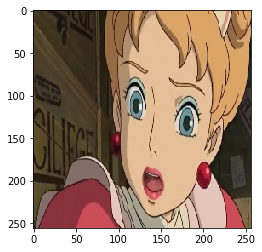

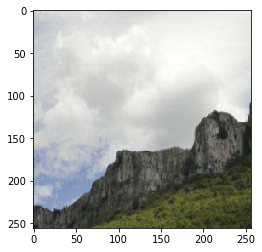

In [16]:
dataset = load_data()
image_shape = None

x = dataset[0][0]
fig, ax = plt.subplots(ncols = 1)
ax.imshow((x * 127.5 + 127.5).astype(int))
plt.show()
image_shape = x.shape
    
y = dataset[1][0]
fig, ax = plt.subplots(ncols = 1)
ax.imshow((y * 127.5 + 127.5).astype(int))
plt.show()

In [17]:
assert image_shape == (256, 256, 3)

In [18]:
generator1 = create_generator()
generator2 = create_generator()
dis1 = create_discriminator()
dis2 = create_discriminator()
composite1 = create_composite_model(generator1, dis2, generator2, image_shape)
composite2 = create_composite_model(generator2, dis1, generator1, image_shape)

In [36]:
# train(dis1, dis2, generator1, generator2, composite1, composite2, dataset)

In [19]:
generator1 = keras.models.load_model('./models/anim_to_real_150000.h5')
generator2 = keras.models.load_model('./models/real_to_anim_150000.h5')
dis1 = keras.models.load_model('./models/dis1150000.h5')
dis2 = keras.models.load_model('./models/dis2150000.h5')

In [20]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [21]:
composite1 = create_composite_model(generator1, dis2, generator2, image_shape)
composite2 = create_composite_model(generator2, dis1, generator1, image_shape)

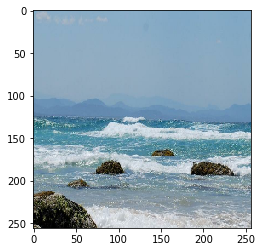

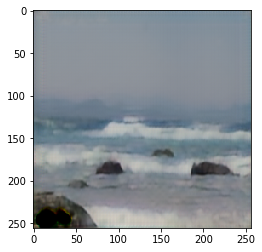

In [41]:
y = dataset[1][9]
fig, ax = plt.subplots(ncols = 1)
ax.imshow((y * 127.5 + 127.5).astype(int))
plt.show()

x_pred = generator2(tf.expand_dims(y, 0))
fig, ax = plt.subplots(ncols = 1)
ax.imshow((x_pred[0] + 1)/2)
plt.show()

In [ ]:
train(dis1, dis2, generator1, generator2, composite1, composite2, dataset, offset=150000)

Losses: 150001, d1[0.002,0.004] d2[0.001,0.005] g[2.598,2.367]
Losses: 150002, d1[0.002,0.000] d2[0.001,0.004] g[2.085,2.295]
Losses: 150003, d1[0.001,0.012] d2[0.002,0.008] g[1.915,2.004]
Losses: 150004, d1[0.001,0.163] d2[0.002,0.001] g[3.168,3.417]
Losses: 150005, d1[0.022,0.000] d2[0.003,0.485] g[2.077,2.589]
Losses: 150006, d1[0.002,0.000] d2[0.001,0.004] g[2.259,2.416]
Losses: 150007, d1[0.001,0.104] d2[0.001,0.001] g[2.500,2.910]
Losses: 150008, d1[0.002,0.001] d2[0.001,0.001] g[1.946,2.097]
Losses: 150009, d1[0.001,0.001] d2[0.136,0.002] g[2.104,2.469]
Losses: 150010, d1[0.001,0.002] d2[0.001,0.001] g[2.365,2.018]
Losses: 150011, d1[0.001,0.001] d2[0.003,0.001] g[1.368,1.453]
Losses: 150012, d1[0.001,0.035] d2[0.001,0.001] g[2.247,1.864]
Losses: 150013, d1[0.001,0.001] d2[0.001,0.002] g[2.610,2.723]
Losses: 150014, d1[0.002,0.002] d2[0.002,0.001] g[2.795,2.644]
Losses: 150015, d1[0.001,0.001] d2[0.002,0.001] g[1.350,1.599]
Losses: 150016, d1[0.001,0.001] d2[0.001,0.007] g[2.658